In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import seaborn as sns 

In [30]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [125]:
data = cg.get_coin_market_chart_range_by_id(id = 'bitcoin', vs_currency='usd',from_timestamp= (datetime.now() - timedelta(days=720)).timestamp(),to_timestamp=datetime.now().timestamp())

In [126]:
df = pd.DataFrame(data)

In [127]:
datetime.fromtimestamp(float(df['prices'][0][0])/1000.0)

datetime.datetime(2019, 12, 12, 5, 30)

In [128]:
df.head()

,prices,market_caps,total_volumes
0,"[1576108800000, 7197.426825880834]","[1576108800000, 130242932604.26935]","[1576108800000, 18016936696.22855]"
1,"[1576195200000, 7200.7070180298015]","[1576195200000, 130489545691.80917]","[1576195200000, 19829801017.961727]"
2,"[1576281600000, 7247.350277010915]","[1576281600000, 131188243085.0565]","[1576281600000, 18535665729.09757]"
3,"[1576368000000, 7081.740255265727]","[1576368000000, 128114177662.37697]","[1576368000000, 19497758114.150417]"
4,"[1576454400000, 7108.563021778046]","[1576454400000, 128886696696.6067]","[1576454400000, 18896096612.075874]"


In [129]:
df['timestamp'] = df['prices'].apply(lambda x : datetime.fromtimestamp(float(x[0])/1000.0))

In [130]:
df['prices'] = df['prices'].apply(lambda x : x[1])
df['market_caps'] = df['market_caps'].apply(lambda x : x[1])
df['total_volumes'] = df['total_volumes'].apply(lambda x : x[1])

In [131]:
df.head()

,prices,market_caps,total_volumes,timestamp
0,7197.426826,1.302429e+11,1.801694e+10,2019-12-12 05:30:00
1,7200.707018,1.304895e+11,1.982980e+10,2019-12-13 05:30:00
2,7247.350277,1.311882e+11,1.853567e+10,2019-12-14 05:30:00
3,7081.740255,1.281142e+11,1.949776e+10,2019-12-15 05:30:00
4,7108.563022,1.288867e+11,1.889610e+10,2019-12-16 05:30:00


In [132]:
df.corr()

,prices,market_caps,total_volumes
prices,1.000000,0.999965,0.432738
market_caps,0.999965,1.000000,0.428982
total_volumes,0.432738,0.428982,1.000000


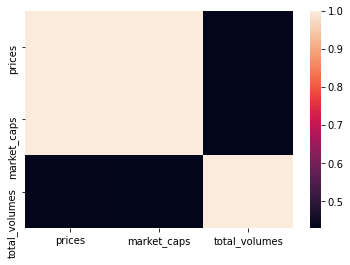

In [133]:
sns.heatmap(df.corr())

In [134]:
df.drop(['market_caps'],axis=1,inplace=True)

In [135]:
df['timestamp'] = df['timestamp'].apply(lambda x : x.date())

In [136]:
df['timestamp'].apply(lambda x : x.date())

AttributeError: 'datetime.date' object has no attribute 'date'

In [137]:
df['timestamp']

0      2019-12-12
1      2019-12-13
2      2019-12-14
3      2019-12-15
4      2019-12-16
          ...    
715    2021-11-26
716    2021-11-27
717    2021-11-28
718    2021-11-29
719    2021-11-30
Name: timestamp, Length: 720, dtype: object

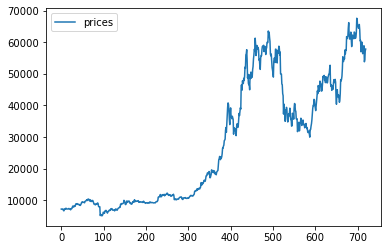

In [138]:
df[['prices','timestamp']].plot()

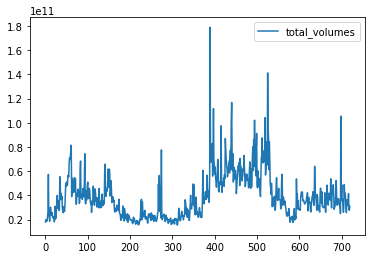

In [139]:
df[['total_volumes','timestamp']].plot()

In [140]:
df['next_day_price'] = df['prices'].shift(periods=-1)

In [141]:
df.head()

,prices,total_volumes,timestamp,next_day_price
0,7197.426826,1.801694e+10,2019-12-12,7200.707018
1,7200.707018,1.982980e+10,2019-12-13,7247.350277
2,7247.350277,1.853567e+10,2019-12-14,7081.740255
3,7081.740255,1.949776e+10,2019-12-15,7108.563022
4,7108.563022,1.889610e+10,2019-12-16,6901.036915


In [142]:
df.isnull().sum()

prices            0
total_volumes     0
timestamp         0
next_day_price    1
dtype: int64

In [149]:
df = df.dropna()

In [ ]:
df.index = df['timestamp']

In [150]:
from sklearn.preprocessing import MinMaxScaler

In [210]:
scaler = MinMaxScaler(feature_range= (-1,1))
scaler_2 = MinMaxScaler(feature_range= (-1,1))
scaler_3 = MinMaxScaler(feature_range= (-1,1))

df_scaled = df.copy(deep=True)

In [211]:
df_scaled['prices'] = scaler.fit_transform(df['prices'].values.reshape(-1,1))
df_scaled['prices'] = np.reshape(df_scaled['prices'],len(df_scaled['prices']))
df_scaled['total_volumes'] = scaler_2.fit_transform(df['total_volumes'].values.reshape(-1,1))

df_scaled['total_volumes'] = np.reshape(df_scaled['total_volumes'],len(df_scaled['total_volumes']))
df_scaled['next_day_price'] = scaler_3.fit_transform(df['next_day_price'].values.reshape(-1,1))

df_scaled['next_day_price'] = np.reshape(df_scaled['next_day_price'],len(df_scaled['next_day_price']))

In [161]:
from sklearn.model_selection import train_test_split

In [146]:
df = df.drop('timestamp',axis=1)

In [212]:
X_train,X_test,Y_train,Y_test = train_test_split(df_scaled[['prices']], df_scaled['next_day_price'])

In [213]:
X_train.shape

(539, 1)

In [214]:
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import Sequential

In [228]:
model=Sequential()
model.add(LSTM(units=200, activation='relu', return_sequences=True, input_shape=(1,1)))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.values.reshape(X_train.shape[0],X_train.shape[1],1),Y_train,epochs=25,batch_size=64,verbose=1)

y_pred=model.predict(X_test.values.reshape(X_test.shape[0],X_test.shape[1],1))

Train on 539 samples
Epoch 1/25
539/539 [==============================] - 3s 6ms/sample - loss: 0.4492
Epoch 2/25
539/539 [==============================] - 0s 185us/sample - loss: 0.4133
Epoch 3/25
539/539 [==============================] - 0s 165us/sample - loss: 0.3677
Epoch 4/25
539/539 [==============================] - 0s 186us/sample - loss: 0.3057
Epoch 5/25
539/539 [==============================] - 0s 167us/sample - loss: 0.2232
Epoch 6/25
539/539 [==============================] - 0s 167us/sample - loss: 0.1360
Epoch 7/25
539/539 [==============================] - 0s 174us/sample - loss: 0.0769
Epoch 8/25
539/539 [==============================] - 0s 151us/sample - loss: 0.0498
Epoch 9/25
539/539 [==============================] - 0s 161us/sample - loss: 0.0294
Epoch 10/25
539/539 [==============================] - 0s 188us/sample - loss: 0.0179
Epoch 11/25
539/539 [==============================] - 0s 177us/sample - loss: 0.0119
Epoch 12/25
539/539 [=======================

In [229]:
y_pred = scaler_3.inverse_transform(y_pred)

In [235]:
from sklearn.metrics import mean_squared_error

In [236]:
y_pred.shape

(180, 1)

In [241]:
print("MSE",np.sqrt(mean_squared_error(Y_test,y_pred)))

MSE 33021.908695108345
